Loading data...
✅ Data Loaded Successfully
✅ Merged Data Points: 158


/tmp/ipython-input-1858741814.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='sentiment_class', y='avg_trade_size', data=merged_df, palette='magma', errorbar=None)


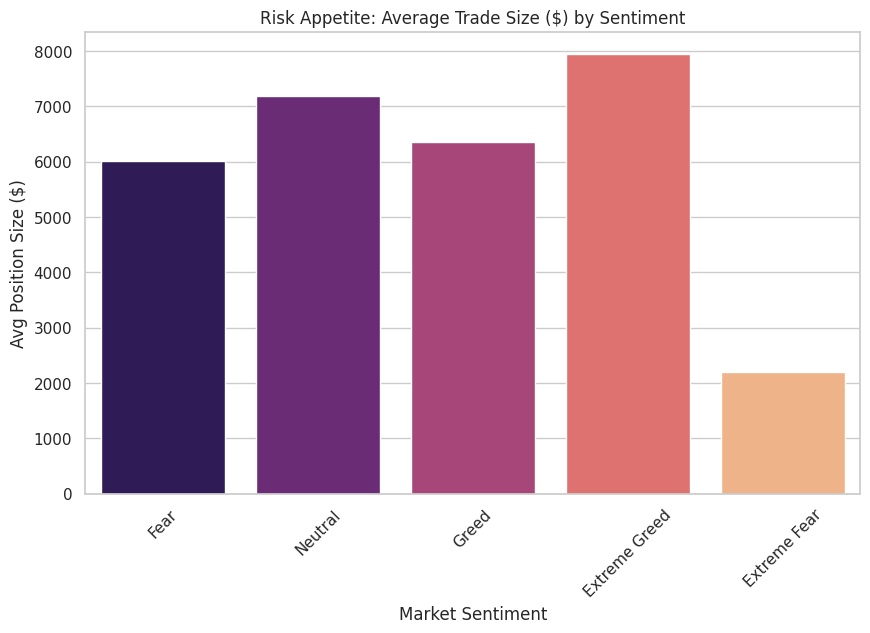

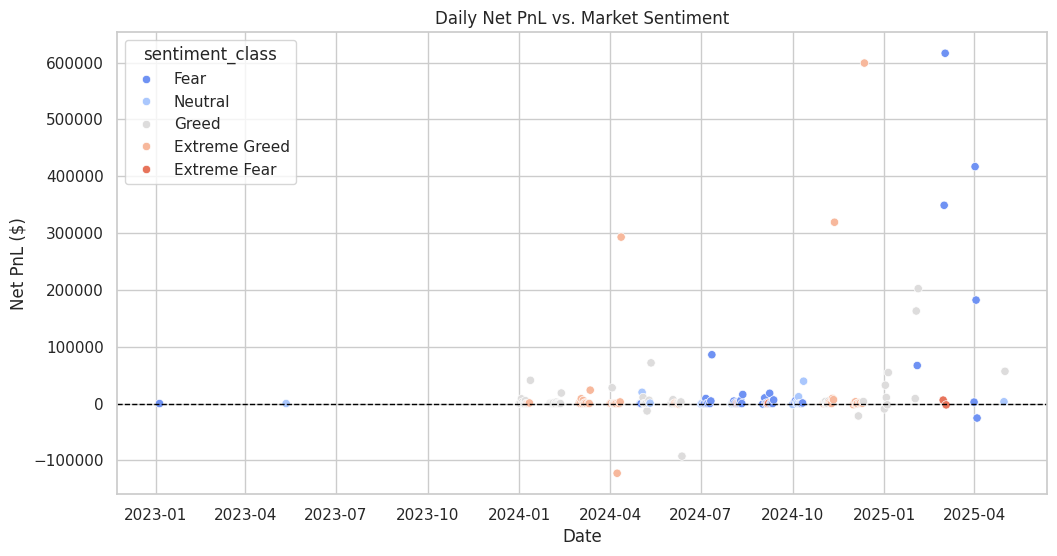

/tmp/ipython-input-1858741814.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentiment_class', y='total_volume', data=merged_df, palette='viridis')


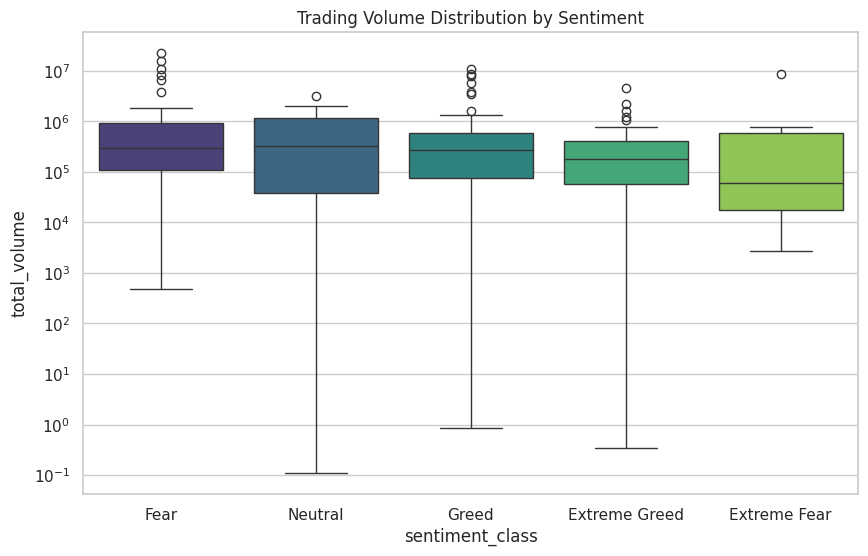

✅ Analysis Complete. Images saved to ds_Sourabh_Khamankar/outputs


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- CONFIGURATION ---
base_dir = 'ds_Sourabh_Khamankar'
csv_dir = f'{base_dir}/csv_files'
output_dir = f'{base_dir}/outputs'

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# ==========================================
# 1. LOAD DATA
# ==========================================
print("Loading data...")
try:
    # Load with the specific filenames you have
    # Note: 'value' and 'classification' are in the index file
    df_sentiment = pd.read_csv(f'{csv_dir}/fear_greed_index.csv')
    df_trades = pd.read_csv(f'{csv_dir}/historical_data.csv')
    print("✅ Data Loaded Successfully")
except FileNotFoundError:
    print("❌ Error: Files not found. Ensure filenames in 'csv_files' match exactly.")

# ==========================================
# 2. DATA CLEANING & PREPROCESSING
# ==========================================

# --- Process Sentiment Data ---
# Your columns: timestamp, value, classification, date
df_sentiment['date'] = pd.to_datetime(df_sentiment['date'])
df_sentiment.rename(columns={'date': 'Date', 'value': 'sentiment_score', 'classification': 'sentiment_class'}, inplace=True)

# --- Process Trader Data ---
# Your columns: Coin, Execution Price, Size Tokens, Size USD, Side, Timestamp IST, ...
# We need to parse 'Timestamp IST'. Assuming format is standard.
# If it contains "IST", we might need to strip it or handle timezone.
# Attempting flexible parsing:
df_trades['Timestamp IST'] = pd.to_datetime(df_trades['Timestamp IST'], errors='coerce')

# Create a clean 'Date' column for merging
df_trades['Date'] = df_trades['Timestamp IST'].dt.normalize()

# ==========================================
# 3. AGGREGATION
# ==========================================
# We group by Date to get Daily metrics.
# Missing 'leverage' column, so we use 'Size USD' (Mean) as a proxy for Risk Appetite.

daily_stats = df_trades.groupby('Date').agg({
    'Order ID': 'count',            # Total number of trades
    'Closed PnL': 'sum',            # Total Profit/Loss
    'Size USD': ['sum', 'mean'],    # Total Volume and Average Trade Size
    'Side': lambda x: (x == 'Short').mean() # Percentage of Short positions
}).reset_index()

# Flatten the multi-level column names
daily_stats.columns = ['Date', 'trade_count', 'net_pnl', 'total_volume', 'avg_trade_size', 'short_ratio']

# ==========================================
# 4. MERGE DATASETS
# ==========================================
merged_df = pd.merge(daily_stats, df_sentiment, on='Date', how='inner')
print(f"✅ Merged Data Points: {len(merged_df)}")

# ==========================================
# 5. VISUALIZATION
# ==========================================
sns.set(style="whitegrid")

# Chart 1: Risk Appetite (Average Trade Size vs Sentiment)
# Instead of Leverage, we check if traders bet BIGGER amounts during Greed.
plt.figure(figsize=(10, 6))
sns.barplot(x='sentiment_class', y='avg_trade_size', data=merged_df, palette='magma', errorbar=None)
plt.title('Risk Appetite: Average Trade Size ($) by Sentiment')
plt.ylabel('Avg Position Size ($)')
plt.xlabel('Market Sentiment')
plt.xticks(rotation=45)
plt.savefig(f'{output_dir}/risk_analysis.png')
plt.show()

# Chart 2: Profitability vs Sentiment
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Date', y='net_pnl', hue='sentiment_class', data=merged_df, palette='coolwarm')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Daily Net PnL vs. Market Sentiment')
plt.ylabel('Net PnL ($)')
plt.savefig(f'{output_dir}/pnl_analysis.png')
plt.show()

# Chart 3: Volume vs Sentiment
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment_class', y='total_volume', data=merged_df, palette='viridis')
plt.title('Trading Volume Distribution by Sentiment')
plt.yscale('log') # Log scale if volume varies wildly
plt.savefig(f'{output_dir}/volume_analysis.png')
plt.show()

print(f"✅ Analysis Complete. Images saved to {output_dir}")